In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
import os
import sys
import json
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gzbuilder_analysis.rendering as rg
import gzbuilder_analysis.fitting as fg
import gzbuilder_analysis.parsing as pg
import gzbuilder_analysis.config as cfg
try:
    from gzbuilder_analysis.rendering.cuda import calculate_model, oversampled_sersic_component
except ModuleNotFoundError:
    from gzbuilder_analysis.rendering import calculate_model, oversampled_sersic_component
from gzbuilder_analysis.fitting import Model, fit_model
from PIL import Image
import argparse
from asinh_cmap import asinh_cmap

In [3]:
fitting_metadata = pd.read_pickle('lib/fitting_metadata.pkl')
# models = pd.read_pickle('lib/models.pickle')

In [4]:
subject_id = 21096941

In [5]:
fm = fitting_metadata.loc[subject_id]
data = fm['galaxy_data']
sigma_image = fm['sigma_image']
psf = fm['psf']

In [6]:
print(f'lib/agg_models/{subject_id}.json')
print('lib/agg_models/21097001.json')

lib/agg_models/21096941.json
lib/agg_models/21097001.json


In [7]:
with open(f'lib/agg_models/{subject_id}.json') as f:
    model = pg.unmake_json(f)
    
with open(f'output_files/tuned_models/agg/{subject_id}.json') as f:
    tuned_model = pg.unmake_json(f)

In [28]:
m = Model(
    model,
    data,
    psf=psf,
    sigma_image=sigma_image
)
m_tuned = Model(
    tuned_model,
    data,
    psf=psf,
    sigma_image=sigma_image
)

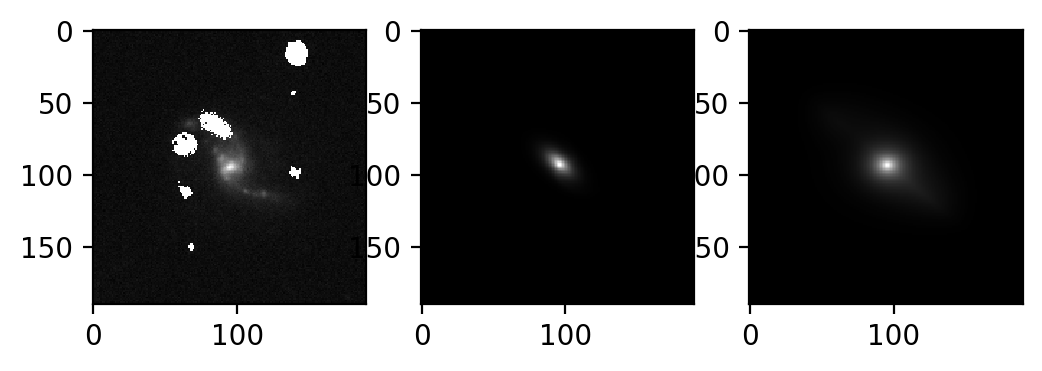

In [29]:
plt.figure(dpi=200)
plt.subplot(131)
plt.imshow(data, cmap=asinh_cmap)
plt.subplot(132)
plt.imshow(m.render(), cmap=asinh_cmap)
plt.subplot(133)
plt.imshow(m_tuned.render(), cmap=asinh_cmap)

In [10]:
print(f'Chisq: {fg.chisq(m.render(), data, sigma_image):.4f}')
print(f'Chisq: {fg.chisq(m_tuned.render(), data, sigma_image):.4f}')

Chisq: 4.0962
Chisq: 1.7835
